In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [3]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

In [4]:
'''ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')'''

"ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')\nmovies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')"

# Dataset

In [5]:
'''percentage = 2
#movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))
ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))'''

'percentage = 2\n#movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))\nratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))'

In [6]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [7]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
#ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [9]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

610
9724


# Spotlight

## Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used when needed.

In [186]:
from collections import defaultdict
from itertools import count
uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (1, uid_map[3]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 1 got uid 2
movieId 54001 got iid 2518


In [188]:
iid_map

defaultdict(<method-wrapper '__next__' of itertools.count object at 0x0000026333312CC8>,
            {1: 0,
             3: 1,
             6: 2,
             47: 3,
             50: 4,
             70: 5,
             101: 6,
             110: 7,
             151: 8,
             157: 9,
             163: 10,
             216: 11,
             223: 12,
             231: 13,
             235: 14,
             260: 15,
             296: 16,
             316: 17,
             333: 18,
             349: 19,
             356: 20,
             362: 21,
             367: 22,
             423: 23,
             441: 24,
             457: 25,
             480: 26,
             500: 27,
             527: 28,
             543: 29,
             552: 30,
             553: 31,
             590: 32,
             592: 33,
             593: 34,
             596: 35,
             608: 36,
             648: 37,
             661: 38,
             673: 39,
             733: 40,
             736: 41,
      

Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

## Implicit Factorization model

In [12]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids,
                                   timestamps = timestamps)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))
implicit_train_features, implicit_train_labels = random_train_test_split(implicit_train, random_state=np.random.seed(42))

In [13]:
print(implicit_train)
print(implicit_test)
print(implicit_val)
print(implicit_train_features)
print(implicit_train_labels)

<Interactions dataset (610 users x 9724 items x 64534 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>
<Interactions dataset (610 users x 9724 items x 16134 interactions)>
<Interactions dataset (610 users x 9724 items x 51627 interactions)>
<Interactions dataset (610 users x 9724 items x 12907 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [14]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    #FOR EACH INTERACTION
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId'] == converted_movies[i]) & (
            ratings_df['userId'] == converted_users[i])].values))

    df = pd.DataFrame({'user_id': converted_users,
                       'movie_id': converted_movies, 'rating': rating})
    return df

In [15]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)
train_features_df = interactionToDataFrame(implicit_train_features)
train_labels_df = interactionToDataFrame(implicit_train_labels)

### Pickle 

Save

In [16]:
'''train_df.to_pickle("./train_df.pkl")
test_df.to_pickle("./test_df.pkl")
val_df.to_pickle("./val_df.pkl")'''

'train_df.to_pickle("./train_df.pkl")\ntest_df.to_pickle("./test_df.pkl")\nval_df.to_pickle("./val_df.pkl")'

Load

In [17]:
'''train_df = pd.read_pickle("./train_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")
val_df = pd.read_pickle("./val_df.pkl")'''

'train_df = pd.read_pickle("./train_df.pkl")\ntest_df = pd.read_pickle("./test_df.pkl")\nval_df = pd.read_pickle("./val_df.pkl")'

### Train Implicit Factorization model 

In [18]:
implicit_model = ImplicitFactorizationModel(n_iter=5)

current = time.time()

implicit_model.fit(implicit_train, verbose=True)

end = time.time()
diff = end - current
print('Training took %d second' % (diff))

Epoch 0: loss 0.7727972939315992
Epoch 1: loss 0.44629176567665674
Epoch 2: loss 0.39687337682181195
Epoch 3: loss 0.3601803479222912
Epoch 4: loss 0.3237792207553924
Training took 48 second


### MRR score

In [19]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

0.27662204135526713


Distribution of scores for a user

(array([4.000e+00, 6.000e+00, 3.100e+01, 7.900e+01, 2.130e+02, 4.550e+02,
        9.800e+02, 1.478e+03, 1.343e+03, 9.470e+02, 6.040e+02, 4.000e+02,
        2.960e+02, 2.230e+02, 2.160e+02, 1.850e+02, 1.620e+02, 1.530e+02,
        1.290e+02, 1.390e+02, 1.270e+02, 1.290e+02, 9.600e+01, 1.100e+02,
        8.500e+01, 9.800e+01, 9.100e+01, 9.100e+01, 1.220e+02, 1.040e+02,
        1.120e+02, 1.220e+02, 1.260e+02, 9.900e+01, 8.800e+01, 4.800e+01,
        2.100e+01, 1.000e+01, 1.000e+00, 1.000e+00]),
 array([-13.502271  , -12.847301  , -12.192329  , -11.537359  ,
        -10.882388  , -10.227418  ,  -9.572448  ,  -8.917477  ,
         -8.2625065 ,  -7.607536  ,  -6.952565  ,  -6.2975945 ,
         -5.642624  ,  -4.9876537 ,  -4.332683  ,  -3.6777124 ,
         -3.0227418 ,  -2.3677714 ,  -1.7128007 ,  -1.0578302 ,
         -0.4028597 ,   0.25211087,   0.9070814 ,   1.562052  ,
          2.2170224 ,   2.871993  ,   3.5269637 ,   4.1819344 ,
          4.8369045 ,   5.491875  ,   6.146846  ,   6.

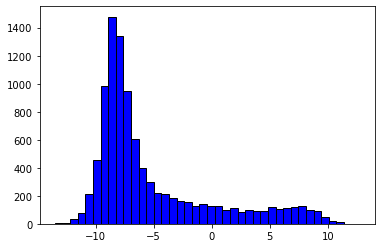

In [20]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

The function below (allUsers_topK_implicit) returns a list that contains the top-K recommendations for each user.

In [21]:
import scipy.stats as st
k = 100
def topK_implicit(user, model, k=100):
  a= list()
  ranks = st.rankdata(-model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0,implicit_model)
print(rec_forUser)

[1, 47, 50, 70, 110, 151, 223, 260, 296, 316, 333, 349, 356, 367, 457, 527, 552, 590, 592, 593, 608, 648, 661, 733, 736, 780, 1042, 1073, 1196, 1197, 1198, 1208, 1210, 1240, 1258, 1265, 1500, 1617, 2000, 2028, 2571, 2640, 2797, 21, 32, 708, 908, 920, 1183, 3897, 39, 150, 261, 344, 589, 597, 10, 17, 25, 95, 141, 165, 168, 185, 208, 292, 293, 317, 337, 339, 377, 434, 454, 494, 520, 587, 1061, 924, 586, 2100, 784, 858, 1527, 1909, 111, 541, 1221, 653, 778, 173, 420, 785, 788, 2248, 2710, 471, 786, 805, 1673, 69]


In [22]:
def allUsers_topK_implicit(model):
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i,model))
    return a

In [23]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9,10,GoldenEye (1995),Action|Adventure|Thriller
16,17,Sense and Sensibility (1995),Drama|Romance
20,21,Get Shorty (1995),Comedy|Crime|Thriller
24,25,Leaving Las Vegas (1995),Drama|Romance
...,...,...,...
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1986,2640,Superman (1978),Action|Adventure|Sci-Fi
2035,2710,"Blair Witch Project, The (1999)",Drama|Horror|Thriller
2103,2797,Big (1988),Comedy|Drama|Fantasy|Romance


In [24]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Μovies watched from a user

In [25]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [26]:
actual = actual.index.tolist()

In [27]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
5,6,Heat (1995),Action|Crime|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
62,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
...,...,...,...
1332,1804,"Newton Boys, The (1998)",Crime|Drama
1333,1805,Wild Things (1998),Crime|Drama|Mystery|Thriller
1401,1920,Small Soldiers (1998),Animation|Children|Fantasy|War
2991,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [28]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score

In [29]:
allUsers_topK_imp = allUsers_topK_implicit(implicit_model)

In [30]:
rec_forUser == allUsers_topK_imp[0]

True

In [31]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

Compute the relevance for each user. The relevance containes 0s and 1s based on which movies each has watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. There is a relevance list for each user.

In [32]:
def relevance_spotlight_implicit(allUsers_topK):
    relevance_implicit_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(allUsers_topK[count])):
            if allUsers_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_implicit_full.append(helper)
        helper = []
        count += 1
    return relevance_implicit_full

In [33]:
relevance_implicit_full = relevance_spotlight_implicit(allUsers_topK_imp)

In [34]:
relevance_implicit == relevance_implicit_full[0]

True

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [35]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [36]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [37]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [38]:
ndcg = NDCG_forUser(relevance_implicit_full[0])
print(ndcg)
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

0.4676080222659298
0.4676080222659298


In [181]:
relevance_implicit_full[0]

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Creation of a list (allUsers_implicit_ndcg) that contains the NDCG score for each user.

In [39]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [40]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Fill the nan values with 0s.

In [41]:
allUsers_implicit_ndcg = pd.Series(allUsers_implicit_ndcg).fillna(0).tolist()

## Implicit Sequence model

In [42]:
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

### Train Implicit Sequence model

In [43]:
'''sequence_model  = ImplicitSequenceModel(n_iter = 5)

current = time.time()
sequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

"sequence_model  = ImplicitSequenceModel(n_iter = 5)\n\ncurrent = time.time()\nsequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)\n\nend = time.time()\ndiff = end - current\nprint('Training took %d second'%(diff))"

In [44]:
#sequence_model.predict(sequences = 9724)

### MRR Score

In [45]:
#print(sequence_mrr_score(sequence_model, implicit_test.to_sequence()).mean())

### Top-K predictions for a user

In [46]:
#allUsers_topK_sequence = allUsers_topK_implicit(sequence_model)

### NDCG Score

In [47]:
#relevance_sequence_full = relevance_spotlight_implicit(allUsers_topK_sequence)

In [48]:
#allUsers_sequence_ndcg = allUsers_ndcg(relevance_sequence_full)

In [49]:
#allUsers_sequence_ndcg = pd.Series(allUsers_sequence_ndcg).fillna(0).tolist()

# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [50]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [51]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193585,193609
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD implementation

In [52]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)

## Predictions

To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [53]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [54]:
svd_predictions_score[1]

array([ 0.02451746, -0.01244209, -0.0170505 , ...,  0.00356973,
        0.00356973,  0.005989  ])

In [55]:
svd_predictions_score_df

movie_id,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193585,193609
0,2.040661,0.892280,0.617109,0.017691,0.212900,1.195460,0.215630,0.019031,0.111706,1.552077,...,-0.005068,-0.003942,-0.003379,-0.004505,-0.004505,-0.003942,-0.004505,-0.003942,-0.003942,-0.020412
1,0.024517,-0.012442,-0.017051,-0.009332,0.007718,0.070573,-0.017636,-0.010118,-0.008187,0.010539,...,0.004590,0.003570,0.003060,0.004080,0.004080,0.003570,0.004080,0.003570,0.003570,0.005989
2,0.049721,0.025048,0.024995,-0.000694,-0.007919,0.050052,-0.002062,0.006981,0.003767,0.020407,...,0.000257,0.000200,0.000172,0.000229,0.000229,0.000200,0.000229,0.000200,0.000200,-0.001786
3,0.733336,0.217520,0.215315,0.054716,0.080936,0.289391,0.095081,-0.023955,0.007672,0.223204,...,-0.004235,-0.003294,-0.002823,-0.003764,-0.003764,-0.003294,-0.003764,-0.003294,-0.003294,-0.009829
4,0.976920,0.878619,0.350346,0.096718,0.509524,0.476752,0.484305,0.014931,0.101136,0.933944,...,-0.001843,-0.001433,-0.001228,-0.001638,-0.001638,-0.001433,-0.001638,-0.001433,-0.001433,-0.001769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,1.508478,0.044629,0.116838,0.323967,0.617661,-2.767050,-0.008600,-0.057709,-0.299133,-1.424921,...,-0.027656,-0.021510,-0.018437,-0.024583,-0.024583,-0.021510,-0.024583,-0.021510,-0.021510,0.025615
606,1.382032,0.741581,0.443869,0.042342,0.224120,0.788028,0.263451,0.011827,0.088013,1.039269,...,-0.004861,-0.003781,-0.003241,-0.004321,-0.004321,-0.003781,-0.004321,-0.003781,-0.003781,-0.016631
607,3.494060,1.480158,0.297595,-0.048183,0.028618,1.485793,0.233359,0.337648,0.068143,2.793548,...,-0.050920,-0.039604,-0.033947,-0.045262,-0.045262,-0.039604,-0.045262,-0.039604,-0.039604,0.016628
608,0.360716,0.321253,0.150927,0.029685,0.192965,0.249299,0.176740,0.004323,0.044299,0.417237,...,0.000443,0.000344,0.000295,0.000393,0.000393,0.000344,0.000393,0.000344,0.000344,-0.000891


In [56]:
svd_predictions_score_df[svd_predictions_score_df.index == 609]

movie_id,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193585,193609
609,-0.419998,3.12241,-0.146116,0.128619,0.076492,1.768072,0.017538,0.432487,-0.014376,-0.084982,...,0.071499,0.05561,0.047666,0.063554,0.063554,0.05561,0.063554,0.05561,0.05561,0.033664


## Top-K recommendations

### First

The function below returns a list that contains the top-100 recommendations for each user

In [57]:
svd_predictions_score_df[svd_predictions_score_df.index == 0].values[0]

array([ 2.04066137,  0.89227966,  0.61710882, ..., -0.00394193,
       -0.00394193, -0.0204123 ])

In [58]:
def SVD_topK_first(score_df):
    topK_svd_rec = []
    for i in range(len(num_users)):
        svd_h_df = pd.DataFrame({'movie_id': score_df[score_df.index == i].columns,
                                 'score': score_df[score_df.index == i].values[0]})
        svd_h_df = svd_h_df.sort_values('score', ascending=False)
        svd_h_df = svd_h_df.head(100)
        topK_svd_rec.append(svd_h_df['movie_id'].values)
    return topK_svd_rec

In [59]:
a = SVD_topK_first(svd_predictions_score_df)

In [180]:
a[0]

'movie_id'

#### NDCG Score

The function below returns the relevance list of a list of movies.

In [61]:
def SVD_relevance_first(score_df):
    svd_topK = SVD_topK_first(score_df)
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [62]:
relevance_first = SVD_relevance_first(svd_predictions_score_df)

In [63]:
np.asarray(relevance_first).shape

(610, 100)

In [64]:
n_f = NDCG_forUser(relevance_first[0])

In [65]:
n_f

0.4029104627706743

Below is the NDCG scores of each user

In [66]:
all_ndcg_f = allUsers_ndcg(relevance_first)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [67]:
all_ndcg_f = pd.Series(all_ndcg_f).fillna(0).tolist()

In [68]:
np.asarray(all_ndcg_f).mean()

0.3923596929327617

### Second

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [69]:
'''def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations'''

"def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):\n    # Get and sort the user's predictions\n    user_row_number = userID - 1 # UserID starts at 1, not 0\n    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1\n    \n    # Get the user's data and merge in the movie information.\n    user_data = original_ratings_df[original_ratings_df.userId == (userID)]\n    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').\n                     sort_values(['rating'], ascending=False)\n                 )\n    # Recommend the highest predicted rating movies that the user hasn't seen yet.\n    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',\n               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort

In [70]:
'''already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
predictions.head()'''

'already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)\npredictions.head()'

The function SVD_topK_allUsers returens a list that contains the top-K recommendations for each user.

In [71]:
'''def SVD_topK_allUsers():
    allUsers_already_rated = []
    allUsers_predictions = []
    for i in range(1,len(num_users)+1):
        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
        allUsers_already_rated.append(already_rated)
        allUsers_predictions.append(predictions)
    return allUsers_predictions'''

'def SVD_topK_allUsers():\n    allUsers_already_rated = []\n    allUsers_predictions = []\n    for i in range(1,len(num_users)+1):\n        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)\n        allUsers_already_rated.append(already_rated)\n        allUsers_predictions.append(predictions)\n    return allUsers_predictions'

#### NDCG Score

The function SVD_relevance returns a list that contains the relevance (0s and 1s) between the top-K recommendations and the movies that each user actually watched.

In [72]:
'''def SVD_relevance():
    svd_topK = SVD_topK_allUsers()
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full'''

"def SVD_relevance():\n    svd_topK = SVD_topK_allUsers()\n    relevance_svd_full = []\n    helper = []\n    count = 0\n    for i in range(1,len(num_users)+1):\n        for j in range(len(svd_topK[count])):\n            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():\n                helper.append(1)\n            else:\n                helper.append(0)\n        relevance_svd_full.append(helper)\n        helper = []\n        count += 1\n    return relevance_svd_full"

In [73]:
#svd_relevance = SVD_relevance()

In [74]:
#allUsers_svd_ndcg = allUsers_ndcg(svd_relevance)

# LightGBM Baseline

##  Feature 1 (Implicit factorization model scores)

Train an implicit factorization model using the train_features dataset

In [76]:
f1_model = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

f1_model.fit(implicit_train_features,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.808980467443419
Epoch 1: loss 0.46292580767433245
Epoch 2: loss 0.41202140223271777
Epoch 3: loss 0.374163293012298
Epoch 4: loss 0.330868722336127
Training took 42 second


### Target Movies

In [77]:
allUsers_topK_f1 = allUsers_topK_implicit(f1_model)
target_positive = allUsers_topK_f1

Add negative samples to the target movies

In [78]:
import random
target_negative = []
for i in range(1,len(num_users)+1):
    target_negative.append(random.choices(train_features_df[train_features_df['user_id']==i]['movie_id'].values, k = 50))

In [79]:
target_movies = []
for i in range(len(num_users)):
    target_movies.append(target_positive[i] + target_negative[i])

Map the target movies to pick the correct predictions based on the item id

In [80]:
def map_movies(target_movies):
    map_target_movies = []
    map_help = []
    for movies in target_movies:
        for movie in movies:
            map_help.append(iid_map[movie])
        map_target_movies.append(map_help)
        map_help = []
    return map_target_movies

Implicit Factorization model Scores

Train implicit on implicit_features_train! and take these scores.

In [81]:
def give_movies_implicit_scores(map_movies):
    implicit_scores = 0
    feature = []
    for i in range(len(num_users)):
        #for movies in map_target_movies:
        my_list = map_movies[i]
        my_array = np.array(my_list)
        implicit_scores = f1_model.predict(user_ids = i,item_ids = my_array)
        feature.append(implicit_scores)
    return feature

In [82]:
map_target_movies = map_movies(target_movies)
feature1 = give_movies_implicit_scores(map_target_movies)
feature1 = np.asarray(feature1)
feature1.shape

(610, 150)

## Feature 2 (Implicit Rank)

In [84]:
feature2 = []
for i in range(len(num_users)):
    my_list = map_target_movies[i]
    my_array = np.array(my_list)
    feature2.append(st.rankdata(f1_model.predict(i,my_array)))

In [85]:
np.array(feature2).shape

(610, 150)

In [167]:
feature2[0]

array([124. ,  51. , 142. , 120. ,  63. , 112. ,  78. , 121.5, 144. ,
       131. , 129. , 125. , 114. ,  97. ,  99. , 150. , 115. ,  94.5,
       123. , 148. , 133. ,  74. ,  87. ,  84. ,  85. ,  56.5, 141. ,
        79. ,  66. ,  67. , 127. ,  70. ,  92. ,  72. ,  73. ,  52. ,
        82. , 111. ,  81. , 108. ,  59. ,  53. ,  76. ,  46. ,  89. ,
        86. , 149. , 102. ,  54. ,  61. ,  90. ,  65. , 146. , 139. ,
       137. ,  50. , 118. , 143. , 138. , 130. , 117. , 104. , 134. ,
       105. ,  71. , 140. ,  77. , 136. , 101. , 147. , 110. , 132. ,
       106. ,  60. , 135. , 107. ,  88. , 145. ,  80. , 119. ,  91. ,
        75. ,  98. , 113. , 116. , 103. , 109. ,  55. ,  96. ,  48. ,
        69. ,  62. ,  64. ,  83. , 100. ,  93. ,  58. ,  47. ,  68. ,
        49. ,  12. ,  26. ,  21. ,  28. ,   6.5,  36.5, 127. ,  24. ,
        31. ,  10.5,  14.5,  33. ,  25. ,  10.5,   6.5,  38. ,  41. ,
        56.5,  39. ,  17. ,  14.5,   3. ,  22. ,   1. ,  41. ,  44.5,
        36.5,  44.5,

## Feature 3 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [87]:
df_movie_features1 = train_features_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [88]:
U1, sigma1, Vt1 = svds(df_movie_features1)
sigma1 = np.diag(sigma1)
svd_predictions_score1 = np.dot(np.dot(U1, sigma1), Vt1)
svd_predictions_score_df1 = pd.DataFrame(svd_predictions_score1, columns = df_movie_features1.columns)

In [89]:
target_movies[0][2]

50

In [90]:
svd_predictions_score_df1[svd_predictions_score_df1.index == 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,190215,190219,193565,193567,193571,193573,193581,193583,193585,193609
0,1.70961,0.985088,0.532766,0.013699,0.327299,1.039689,0.308421,0.048371,0.079361,1.348522,...,-0.001391,-0.000927,-0.005166,-0.004428,-0.005903,-0.005903,-0.005903,-0.005166,-0.005166,-0.015981


In [91]:
float(svd_predictions_score_df1[svd_predictions_score_df1.index == 0][target_movies[0][0]].values)

1.7096095206750834

In [92]:
feature3 = []
feature3_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature3_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature3.append(feature3_user)
    feature3_user = []

In [93]:
np.array(feature3).shape

(610, 150)

## Feature 4 (Genre)

In [94]:
def create_genre_feature(genre):
    feature = []
    genre_per_user = []
    for i in range(len(num_users)):
        for j in range(len(target_movies[i])):
            a =  movies_df[movies_df['movieId'] == target_movies[i][j]]['genres']
            a = a.tolist()
            a = str(a[0])
            a = a.split('|')
            if genre in a:
                genre_per_user.append(1)
            else:
                genre_per_user.append(0)
        feature.append(genre_per_user)
        genre_per_user = []
    return feature

In [95]:
feature4 = create_genre_feature('Comedy')
np.array(feature4).shape

(610, 150)

### Features 8-15 (genres)

In [96]:
feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')

## Feature 5 (#Users watched each target movie)

In [97]:
number_views = []
number_view_per_movie = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['movieId'] == target_movies[i][j]]['userId'])
        number_view_per_movie.append(a)
    number_views.append(number_view_per_movie)
    number_view_per_movie = []


In [98]:
feature5 = number_views

In [99]:
np.array(feature5).shape

(610, 150)

## Feature 6 (New user)

In [100]:
len(ratings_df[ratings_df['userId']==1]) < 20

False

In [101]:
new_users_binary = []
binary_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['userId']==1]) < 20
        if a:
            binary_per_user.append(a)
        else:
            binary_per_user.append(a)
    new_users_binary.append(binary_per_user)
    binary_per_user = []

In [102]:
#rankings of old/new users

In [103]:
feature6 = new_users_binary

In [104]:
np.array(feature6).shape

(610, 150)

## Feature 7(Embeddings) x32

In [105]:
emb = f1_model._net.item_embeddings

In [106]:
emb_features = []
helper = []
for i in range(32):
    for j in range(len(num_items)):
        helper.append(emb.weight[j][i].item())
    emb_features.append(helper)
    helper = []

In [107]:
a = []
b = []
feature7 = []
for i in range(32):
    for user in range(len(num_users)):
        for movie in map_target_movies[user]:
            a.append(emb_features[0][movie])
        b.append(a)
        a = []
    feature7.append(b)
    b = []

In [108]:
np.array(feature7).shape

(32, 610, 150)

In [109]:
np.array(feature7[0]).shape

(610, 150)

## Feature 47 (SVD Rank)

In [110]:
feature47 = []
feature47_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature47_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature47.append(st.rankdata(feature47_user))
    feature47_user = []

In [111]:
np.array(feature47).shape

(610, 150)

## Features stack

In [112]:
features = np.stack((feature1,feature2,feature3,feature4,feature5,
                     feature7[0], feature7[1],feature7[2], feature7[3],
                     feature7[4], feature7[5],feature7[6], feature7[7],
                     feature7[8], feature7[9],feature7[10], feature7[11],
                     feature7[12], feature7[13],feature7[14], feature7[15],
                     feature7[16], feature7[17],feature7[18], feature7[19],
                     feature7[20], feature7[21],feature7[22], feature7[23],
                     feature7[24], feature7[25],feature7[26], feature7[27],
                     feature7[28], feature7[29],feature7[30], feature7[31],
                     feature8,feature9,feature10,feature11,feature12,
                    feature13,feature14,feature15,feature47))

In [113]:
len(features)

46

## Labels

Below are the movies that each user watched

### CHECK!!

In [114]:
def watched_movies(df):
    watched = []
    for i in range(len(num_users)):
        watched.append(df[df["user_id"]==uid_rev_map.get(i)].groupby("movie_id")["movie_id"].count().index)  
    return watched

In [115]:
#train_labels_df
#test_df
#val_df
train_watched = watched_movies(train_labels_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [116]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [117]:
label_train = create_target(train_watched)
label_test = create_target(test_watched)
label_val = create_target(val_watched)
#y_train = y_test = y_val

## LightGBM model

In [118]:
X = np.array(features)
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)

In [119]:
k = len(target_movies[0])
X = X.reshape(len(num_users)*k, len(features))
y_train = label_train.reshape(len(num_users)*k,)
y_test = label_test.reshape(len(num_users)*k,)
y_val = label_val.reshape(len(num_users)*k,)

In [120]:
import lightgbm as lgb
gbm = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)

In [121]:
X_train = X
X_test = X
X_val = X

In [172]:
print(len(train_df.user_id.unique()))
print(len(test_df.user_id.unique()))
print(len(val_df.user_id.unique()))
print(len(train_features_df.user_id.unique()))
print(len(train_labels_df.user_id.unique()))

610
609
609
610
605


In [122]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)

[91500]
[91500]
[91500]


In [190]:
group_train

[150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150

In [123]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10],  eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.183607	valid_0's ndcg@3: 0.185055	valid_0's ndcg@5: 0.190427	valid_0's ndcg@10: 0.203983
[2]	valid_0's ndcg@1: 0.17541	valid_0's ndcg@3: 0.176473	valid_0's ndcg@5: 0.179953	valid_0's ndcg@10: 0.190823
[3]	valid_0's ndcg@1: 0.170492	valid_0's ndcg@3: 0.167047	valid_0's ndcg@5: 0.173656	valid_0's ndcg@10: 0.183339
[4]	valid_0's ndcg@1: 0.17541	valid_0's ndcg@3: 0.166916	valid_0's ndcg@5: 0.170092	valid_0's ndcg@10: 0.18041
[5]	valid_0's ndcg@1: 0.178689	valid_0's ndcg@3: 0.170378	valid_0's ndcg@5: 0.17348	valid_0's ndcg@10: 0.187374
[6]	valid_0's ndcg@1: 0.162295	valid_0's ndcg@3: 0.167797	valid_0's ndcg@5: 0.171245	valid_0's ndcg@10: 0.184028
[7]	valid_0's ndcg@1: 0.162295	valid_0's ndcg@3: 0.171426	valid_0's ndcg@5: 0.17406	valid_0's ndcg@10: 0.183372
[8]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.167077	valid_0's ndcg@5: 0.173908	valid_0's ndcg@10: 0.182947
[9]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.170306	valid_0's ndcg@5: 0.172399	valid_0's ndcg@1

[76]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.162361	valid_0's ndcg@5: 0.166102	valid_0's ndcg@10: 0.178799
[77]	valid_0's ndcg@1: 0.160656	valid_0's ndcg@3: 0.163364	valid_0's ndcg@5: 0.167194	valid_0's ndcg@10: 0.179201
[78]	valid_0's ndcg@1: 0.160656	valid_0's ndcg@3: 0.163415	valid_0's ndcg@5: 0.165587	valid_0's ndcg@10: 0.179082
[79]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.162396	valid_0's ndcg@5: 0.166056	valid_0's ndcg@10: 0.178512
[80]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.16191	valid_0's ndcg@5: 0.16615	valid_0's ndcg@10: 0.178976
[81]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.163215	valid_0's ndcg@5: 0.166869	valid_0's ndcg@10: 0.179432
[82]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.163934	valid_0's ndcg@5: 0.166996	valid_0's ndcg@10: 0.179298
[83]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.16261	valid_0's ndcg@5: 0.167921	valid_0's ndcg@10: 0.180118
[84]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.16169	valid_0's ndcg@5: 0.166806	valid_

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [124]:
test_pred = gbm.predict(X_test)
np.array(test_pred).shape

(91500,)

## NDCG Score

In [125]:
test_pred[150]

-0.22622076227822488

In [126]:
p = 0
m = k
lgbm_pred_per_user = []
for i in range(len(num_users)):
    lgbm_pred_per_user.append(test_pred[p:m])
    p += k
    m += k

### NDCG IFM on this data

In [127]:
np.array(feature7[0][609]).shape

(150,)

In [128]:
feature1.shape

(610, 150)

In [129]:
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                             'rank': feature2[i], 'model2_score': feature3[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             #'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank':feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('model1_score', ascending=False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('model2_score', ascending=False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [130]:
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
IFM_NDCG = pd.Series(IFM_NDCG).fillna(0).tolist()
SVD_NDCG = pd.Series(SVD_NDCG).fillna(0).tolist()

## Excel-Like

In [131]:
ind = 609
excel1_df = pd.DataFrame({'movie_id': target_movies[ind],'rank':feature2[ind],'model1_score':feature1[ind], 'model2_score':feature3[ind],'is_comedy':feature4[ind],
                            '#users_watched':feature5[ind], 'train_label':label_train[ind], 'test_label':label_test[ind],
                            'label_val':label_val[ind],'LGBM Score':-lgbm_pred_per_user[ind]})

In [132]:
excel1_df

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,71535,67.0,10.824522,2.949162,1,53,0,1,0,-0.022333
1,91529,150.0,15.614038,2.464663,0,76,0,1,0,0.030668
2,106782,73.0,10.992192,2.638554,1,54,0,0,0,0.108127
3,122882,84.0,11.228768,3.415342,0,47,0,0,0,0.177376
4,4226,79.0,11.138525,3.089396,0,159,0,0,0,0.366532
...,...,...,...,...,...,...,...,...,...,...
145,56367,41.0,8.383044,2.982466,1,65,0,0,0,0.146934
146,1213,10.0,5.274220,2.414592,0,126,0,0,0,-0.042348
147,6383,31.0,7.251142,0.767328,0,19,0,0,0,0.366255
148,113862,5.0,4.696408,0.725649,0,1,0,0,0,0.229527


In [133]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
9,31878,78.0,11.116215,2.020159,1,19,0,0,0,0.847936
51,103772,106.5,11.782988,2.122305,0,16,0,0,0,0.759925
29,4878,146.0,14.176178,2.366664,0,109,0,0,1,0.699416
101,150401,15.0,5.693315,0.831631,0,2,0,0,0,0.591893
37,8784,111.0,11.879091,0.792712,1,48,1,0,0,0.579881
130,4718,4.0,4.639854,1.539216,1,45,0,0,0,0.532728
15,69844,75.0,11.031794,0.502845,0,58,0,0,1,0.532674
71,8983,147.0,14.496237,1.877547,0,25,0,0,0,0.523538
149,3108,12.0,5.362975,2.167906,1,36,0,0,0,0.461846
97,57504,137.0,12.757427,1.382177,1,10,0,0,0,0.422936


In [134]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [135]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

0.40637601039286614

## NDCG Comparison

In [136]:
ndcg_df = pd.DataFrame({'LightGBM': lgbm_NDCG, 'IFM_this': IFM_NDCG,
                        'SVD_this': SVD_NDCG})

In [137]:
ndcg_df

,LightGBM,IFM_this,SVD_this
0,0.396768,0.371701,0.376626
1,0.182233,0.281563,0.518887
2,0.000000,0.000000,0.000000
3,0.226777,0.230174,0.241912
4,0.185449,0.146900,0.262650
...,...,...,...
605,0.513181,0.370157,0.379917
606,0.375678,0.438916,0.722010
607,0.420549,0.497850,0.500952
608,0.257541,0.302992,0.343273


In [138]:
lgbm_mean = ndcg_df['LightGBM'].mean()
lgbm_mean

0.2854083984834854

In [139]:
ifm_mean = ndcg_df['IFM_this'].mean()
ifm_mean

0.32996441300496276

In [140]:
svd_mean = ndcg_df['SVD_this'].mean()
svd_mean

0.35284445166406964

## Visualization

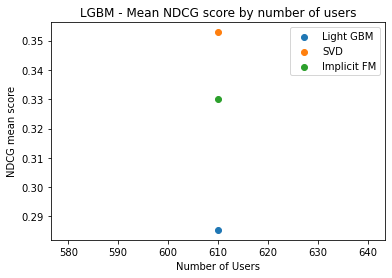

In [141]:
plt.scatter(len(num_users),lgbm_mean,label = 'Light GBM')
plt.scatter(len(num_users),svd_mean, label = 'SVD')
plt.scatter(len(num_users),ifm_mean, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('NDCG mean score')
plt.title('LGBM - Mean NDCG score by number of users')
plt.legend()

In [142]:
a = excel_df.columns.values
a[1:47]

array(['model1_score', 'rank', 'model2_score', 'is_comedy',
       '#users_watched', 'emedding1', 'emedding2', 'emedding3',
       'emedding4', 'emedding5', 'emedding6', 'emedding7', 'emedding8',
       'emedding9', 'emedding10', 'emedding11', 'emedding12',
       'emedding13', 'emedding14', 'emedding15', 'emedding16',
       'emedding17', 'emedding18', 'emedding19', 'emedding20',
       'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28',
       'emedding29', 'emedding30', 'emedding31', 'emedding32',
       'is_adventure', 'is_drama', 'is_romance', 'is_fantasy',
       'is_thriller', 'is_animation', 'is_children', 'is_horror',
       'SVD Rank'], dtype=object)

## Feature Importance

In [143]:
feature_names = excel_df.columns.values[1:47]

Text(0.5, 1.0, 'Importance of Features')

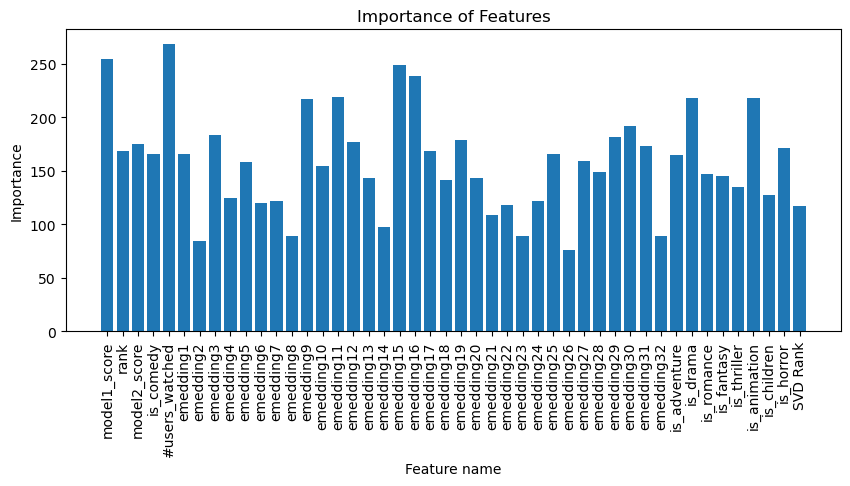

In [144]:
from matplotlib.pyplot import figure
figure(figsize=(10, 4),dpi=100)
plt.bar(feature_names,gbm.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [145]:
gbm.feature_importances_

array([254.53113043, 168.64592159, 174.84091139, 165.91207886,
       268.62748921, 165.70471954,  84.74623001, 183.56178832,
       124.27221072, 158.08515871, 120.37177968, 121.46657085,
        88.8861613 , 217.01028571, 154.52250981, 219.30154991,
       177.14843023, 143.69112849,  97.78471556, 249.03595078,
       238.38671148, 168.75822961, 141.73662996, 178.9474567 ,
       143.2147516 , 109.03731966, 117.8186307 ,  89.46332061,
       121.62260067, 165.66860974,  76.17609954, 159.33714914,
       149.07803917, 181.97788095, 191.63240123, 172.80567861,
        88.74101114, 165.13659024, 217.73826981, 146.85204077,
       144.7932291 , 135.25060034, 218.13230884, 127.90425134,
       171.10225916, 117.29637027])

## Save comparison

In [146]:
#ndcg_df.to_pickle("./ndcg_f1-15_minus67_100k_negative_rank.pkl")

# Research Questions

## What is the impact of genre features one the effectiveness of a model for movie recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 
3. Which genre matter the most (biggest impact on performance)

### No genre features

In [147]:
no_genre_features = np.stack((feature1,feature2,feature3,feature5,
                     feature7[0], feature7[1],feature7[2], feature7[3],
                     feature7[4], feature7[5],feature7[6], feature7[7],
                     feature7[8], feature7[9],feature7[10], feature7[11],
                     feature7[12], feature7[13],feature7[14], feature7[15],
                     feature7[16], feature7[17],feature7[18], feature7[19],
                     feature7[20], feature7[21],feature7[22], feature7[23],
                     feature7[24], feature7[25],feature7[26], feature7[27],
                     feature7[28], feature7[29],feature7[30], feature7[31],feature47))

In [148]:
X_no_genre = np.array(no_genre_features)
X_no_genre = X_no_genre.reshape(len(num_users)*k, len(no_genre_features))
X_train_no_genre = X_no_genre
X_test_no_genre = X_no_genre
X_val_no_genre = X_no_genre

In [173]:
gbm1 = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)
gbm1.fit(X_train_no_genre, y_train, group=group_train,
        eval_set=[(X_val_no_genre, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.172131	valid_0's ndcg@3: 0.180464	valid_0's ndcg@5: 0.183187	valid_0's ndcg@10: 0.194367
[2]	valid_0's ndcg@1: 0.170492	valid_0's ndcg@3: 0.171512	valid_0's ndcg@5: 0.172013	valid_0's ndcg@10: 0.183054
[3]	valid_0's ndcg@1: 0.160656	valid_0's ndcg@3: 0.163853	valid_0's ndcg@5: 0.169048	valid_0's ndcg@10: 0.179493
[4]	valid_0's ndcg@1: 0.162295	valid_0's ndcg@3: 0.165964	valid_0's ndcg@5: 0.166901	valid_0's ndcg@10: 0.179929
[5]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.16268	valid_0's ndcg@5: 0.165924	valid_0's ndcg@10: 0.177515
[6]	valid_0's ndcg@1: 0.152459	valid_0's ndcg@3: 0.158681	valid_0's ndcg@5: 0.161143	valid_0's ndcg@10: 0.172762
[7]	valid_0's ndcg@1: 0.155738	valid_0's ndcg@3: 0.157478	valid_0's ndcg@5: 0.161899	valid_0's ndcg@10: 0.172178
[8]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.163048	valid_0's ndcg@5: 0.16545	valid_0's ndcg@10: 0.174835
[9]	valid_0's ndcg@1: 0.163934	valid_0's ndcg@3: 0.165338	valid_0's ndcg@5: 0.166669	valid_0's ndc

[80]	valid_0's ndcg@1: 0.15082	valid_0's ndcg@3: 0.152626	valid_0's ndcg@5: 0.159838	valid_0's ndcg@10: 0.175092
[81]	valid_0's ndcg@1: 0.147541	valid_0's ndcg@3: 0.152159	valid_0's ndcg@5: 0.158313	valid_0's ndcg@10: 0.173748
[82]	valid_0's ndcg@1: 0.15082	valid_0's ndcg@3: 0.153981	valid_0's ndcg@5: 0.15858	valid_0's ndcg@10: 0.174861
[83]	valid_0's ndcg@1: 0.15082	valid_0's ndcg@3: 0.153597	valid_0's ndcg@5: 0.157331	valid_0's ndcg@10: 0.173749
[84]	valid_0's ndcg@1: 0.15082	valid_0's ndcg@3: 0.154467	valid_0's ndcg@5: 0.158256	valid_0's ndcg@10: 0.17445
[85]	valid_0's ndcg@1: 0.15082	valid_0's ndcg@3: 0.154852	valid_0's ndcg@5: 0.158089	valid_0's ndcg@10: 0.173288
[86]	valid_0's ndcg@1: 0.14918	valid_0's ndcg@3: 0.154852	valid_0's ndcg@5: 0.158235	valid_0's ndcg@10: 0.174916
[87]	valid_0's ndcg@1: 0.15082	valid_0's ndcg@3: 0.154751	valid_0's ndcg@5: 0.158833	valid_0's ndcg@10: 0.173513
[88]	valid_0's ndcg@1: 0.14918	valid_0's ndcg@3: 0.154852	valid_0's ndcg@5: 0.158954	valid_0's nd

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

Text(0.5, 1.0, 'Importance of Features')

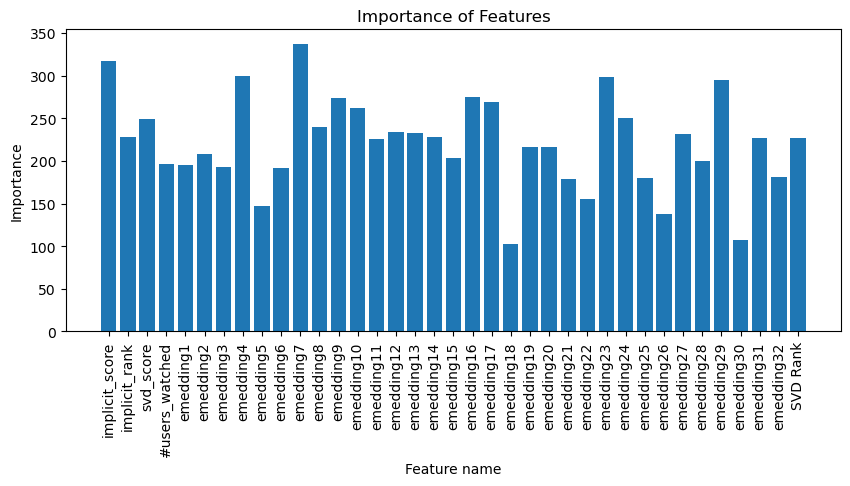

In [174]:
feature_names_no_genre = ('implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
                 'emedding1', 'emedding2', 'emedding3',
                 'emedding4', 'emedding5', 'emedding6',
                 'emedding7', 'emedding8', 'emedding9',
                 'emedding10', 'emedding11', 'emedding12',
                 'emedding13', 'emedding14', 'emedding15',
                 'emedding16', 'emedding17', 'emedding18',
                 'emedding19', 'emedding20', 'emedding21',
                 'emedding22', 'emedding23', 'emedding24',
                 'emedding25', 'emedding26', 'emedding27',
                 'emedding28', 'emedding29', 'emedding30',
                 'emedding31', 'emedding32', 'SVD Rank')
figure(figsize = (10, 4), dpi = 100)
plt.bar(feature_names_no_genre, gbm1.feature_importances_)
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [175]:
gbm1.feature_importances_

array([316.93022156, 228.0668788 , 249.5440408 , 196.02455902,
       194.74373007, 207.7073704 , 193.29485893, 300.06416082,
       147.52258098, 191.49094069, 337.37848854, 240.20685005,
       274.36656153, 262.12353051, 226.27074897, 233.8915205 ,
       233.16579187, 228.04151177, 203.3786912 , 274.50618148,
       269.00950098, 102.18787026, 215.95119762, 215.8585788 ,
       179.03860044, 154.97067904, 298.33708799, 250.65404963,
       179.75777006, 137.58089924, 231.86169076, 200.39797974,
       295.23442078, 107.22415018, 227.15125024, 181.20224237,
       227.30938256])

In [177]:
st.spearmanr(np.array(feature1).reshape(len(num_users)*k,), np.array(feature3).reshape(len(num_users)*k,))

SpearmanrResult(correlation=0.42897414539429335, pvalue=0.0)

In [178]:
st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm1.predict(X_test_no_genre).reshape(len(num_users)*k,))

SpearmanrResult(correlation=-0.004585555103938499, pvalue=0.1654199953238047)

In [191]:
pred_no_genre = gbm1.predict(X_test_no_genre)
len(pred_no_genre)

91500

## What is the impact of items' embeddings features on the effectiveness of a model for item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No item embeddings features

In [154]:
no_embeddings_features = np.stack((feature1,feature2,feature3,feature4,feature5,feature8,
                              feature9,feature10,feature11,feature12,feature13,
                              feature14,feature15,feature47))

In [155]:
X_no_emb = np.array(no_embeddings_features)
X_no_emb = X_no_emb.reshape(len(num_users)*k, len(no_embeddings_features))
X_train_no_emb = X_no_emb
X_test_no_emb = X_no_emb
X_val_no_emb = X_no_emb

In [156]:
gbm2 = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)
gbm2.fit(X_train_no_emb, y_train, group=group_train,
        eval_set=[(X_val_no_emb, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], early_stopping_rounds = 50, eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.185246	valid_0's ndcg@3: 0.182387	valid_0's ndcg@5: 0.186362	valid_0's ndcg@10: 0.196917
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@1: 0.167213	valid_0's ndcg@3: 0.171353	valid_0's ndcg@5: 0.179177	valid_0's ndcg@10: 0.189001
[3]	valid_0's ndcg@1: 0.160656	valid_0's ndcg@3: 0.169253	valid_0's ndcg@5: 0.171067	valid_0's ndcg@10: 0.180929
[4]	valid_0's ndcg@1: 0.160656	valid_0's ndcg@3: 0.165959	valid_0's ndcg@5: 0.169377	valid_0's ndcg@10: 0.179946
[5]	valid_0's ndcg@1: 0.160656	valid_0's ndcg@3: 0.165859	valid_0's ndcg@5: 0.171759	valid_0's ndcg@10: 0.183764
[6]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.170572	valid_0's ndcg@5: 0.173512	valid_0's ndcg@10: 0.180795
[7]	valid_0's ndcg@1: 0.163934	valid_0's ndcg@3: 0.166842	valid_0's ndcg@5: 0.171692	valid_0's ndcg@10: 0.180933
[8]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.165373	valid_0's ndcg@5: 0.170522	valid_0's ndcg@10: 0.178681
[9]	valid_0's ndcg@1: 0.165574	vali

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [157]:
len(gbm2.feature_importances_)

14

Text(0.5, 1.0, 'Importance of Features')

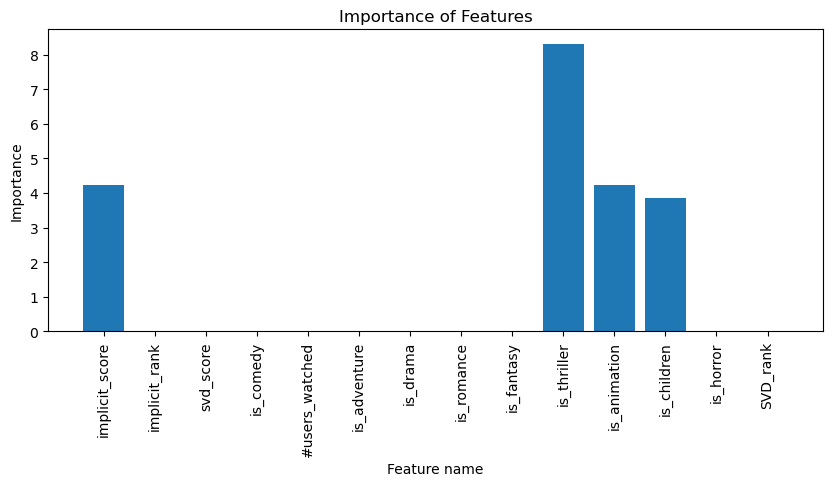

In [158]:
feature_names_no_emb = ('implicit_score', 'implicit_rank', 'svd_score', 'is_comedy', '#users_watched',
                        'is_adventure', 'is_drama', 'is_romance', 'is_fantasy', 'is_thriller',
                        'is_animation', 'is_children', 'is_horror', 'SVD_rank')

figure(figsize=(10, 4), dpi=100)
plt.bar(feature_names_no_emb, gbm2.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [159]:
gbm2.feature_importances_

array([4.23787022, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 8.30962014,
       4.2290802 , 3.86019993, 0.        , 0.        ])

In [160]:
st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm2.predict(X_test_no_emb).reshape(len(num_users)*k,))

SpearmanrResult(correlation=-0.0016214399295007207, pvalue=0.6238066949260361)

In [161]:
st.spearmanr(np.array(feature1).reshape(len(num_users)*k,), np.array(feature14).reshape(len(num_users)*k,))

SpearmanrResult(correlation=0.027241815166327413, pvalue=1.6966093307268865e-16)

In [162]:
pred_no_emb = gbm2.predict(X_test_no_emb)

## What is the impact of the items’rank on the effectivenessof amodelfor item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No models' rank features

In [163]:
no_rank_features = np.stack((feature1, feature3, feature4, feature5, feature7[0],
                             feature7[1], feature7[2], feature7[3],
                             feature7[4], feature7[5], feature7[6], feature7[7],
                             feature7[8], feature7[9], feature7[10], feature7[11],
                             feature7[12], feature7[13], feature7[14], feature7[15],
                             feature7[16], feature7[17], feature7[18], feature7[19],
                             feature7[20], feature7[21], feature7[22], feature7[23],
                             feature7[24], feature7[25], feature7[26], feature7[27],
                             feature7[28], feature7[29], feature7[30], feature7[31],
                             feature8, feature9, feature10, feature11, feature12, feature13,
                             feature14, feature15))

In [164]:
X_no_rank = np.array(no_rank_features)
X_no_rank = X_no_rank.reshape(len(num_users)*k, len(no_rank_features))
X_train_no_rank = X_no_rank
X_test_no_rank = X_no_rank
X_val_no_rank = X_no_rank

In [165]:
gbm3 = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)
gbm3.fit(X_train_no_rank, y_train, group=group_train,
        eval_set=[(X_val_no_rank, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10],eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.188525	valid_0's ndcg@3: 0.18966	valid_0's ndcg@5: 0.195114	valid_0's ndcg@10: 0.209495
[2]	valid_0's ndcg@1: 0.183607	valid_0's ndcg@3: 0.176419	valid_0's ndcg@5: 0.179125	valid_0's ndcg@10: 0.188119
[3]	valid_0's ndcg@1: 0.165574	valid_0's ndcg@3: 0.170495	valid_0's ndcg@5: 0.17075	valid_0's ndcg@10: 0.17855
[4]	valid_0's ndcg@1: 0.165574	valid_0's ndcg@3: 0.168551	valid_0's ndcg@5: 0.168899	valid_0's ndcg@10: 0.178261
[5]	valid_0's ndcg@1: 0.163934	valid_0's ndcg@3: 0.165955	valid_0's ndcg@5: 0.167429	valid_0's ndcg@10: 0.175337
[6]	valid_0's ndcg@1: 0.165574	valid_0's ndcg@3: 0.167914	valid_0's ndcg@5: 0.16784	valid_0's ndcg@10: 0.176283
[7]	valid_0's ndcg@1: 0.163934	valid_0's ndcg@3: 0.16261	valid_0's ndcg@5: 0.168945	valid_0's ndcg@10: 0.176237
[8]	valid_0's ndcg@1: 0.170492	valid_0's ndcg@3: 0.169718	valid_0's ndcg@5: 0.169457	valid_0's ndcg@10: 0.177497
[9]	valid_0's ndcg@1: 0.168852	valid_0's ndcg@3: 0.167663	valid_0's ndcg@5: 0.169962	valid_0's ndcg@1

[76]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.160618	valid_0's ndcg@5: 0.165161	valid_0's ndcg@10: 0.176049
[77]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.160282	valid_0's ndcg@5: 0.165417	valid_0's ndcg@10: 0.176045
[78]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.160168	valid_0's ndcg@5: 0.1666	valid_0's ndcg@10: 0.175476
[79]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.161755	valid_0's ndcg@5: 0.166443	valid_0's ndcg@10: 0.17551
[80]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.161939	valid_0's ndcg@5: 0.166003	valid_0's ndcg@10: 0.175163
[81]	valid_0's ndcg@1: 0.155738	valid_0's ndcg@3: 0.161755	valid_0's ndcg@5: 0.166284	valid_0's ndcg@10: 0.175012
[82]	valid_0's ndcg@1: 0.155738	valid_0's ndcg@3: 0.163728	valid_0's ndcg@5: 0.167299	valid_0's ndcg@10: 0.175538
[83]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.163412	valid_0's ndcg@5: 0.167199	valid_0's ndcg@10: 0.175553
[84]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.16398	valid_0's ndcg@5: 0.167049	valid_

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [166]:
len(feature_names_no_rank)

NameError: name 'feature_names_no_rank' is not defined

In [ ]:
feature_names_no_rank = ('implicit_score', 'svd_score', 'is_comedy', '#users_watched',
                        'emedding1', 'emedding2', 'emedding3',
                        'emedding4', 'emedding5', 'emedding6',
                        'emedding7', 'emedding8', 'emedding9',
                        'emedding10', 'emedding11', 'emedding12',
                        'emedding13', 'emedding14', 'emedding15',
                        'emedding16', 'emedding17', 'emedding18',
                        'emedding19', 'emedding20', 'emedding21',
                        'emedding22', 'emedding23', 'emedding24',
                        'emedding25', 'emedding26', 'emedding27',
                        'emedding28', 'emedding29', 'emedding30',
                        'emedding31', 'emedding32',
                        'is_adventure', 'is_drama', 'is_romance', 'is_fantasy', 'is_thriller',
                        'is_animation', 'is_children', 'is_horror')

figure(figsize=(10, 4), dpi=100)
plt.bar(feature_names_no_rank, gbm3.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [ ]:
gbm3.feature_importances_

In [ ]:
st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm3.predict(X_test_no_rank).reshape(len(num_users)*k,))

In [ ]:
st.spearmanr(np.array(feature1).reshape(len(num_users)*k,), np.array(feature14).reshape(len(num_users)*k,))

In [ ]:
pred_no_rank = gbm3.predict(X_test_no_rank)

# Draft

## Excel-Like

In [ ]:
excel1_df = pd.DataFrame({'movie_id': target_movies[0],'rank':feature2[0],'model1_score':feature1[0], 'model2_score':feature3[0],'is_comedy':feature4[0],
                            '#users_watched':feature5[0], 'train_label':label_train[0], 'test_label':label_test[0],
                            'label_val':label_val[0],'LGBM Score':lgbm_pred_per_user[0]})

In [ ]:
excel1_df

In [ ]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

In [ ]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [ ]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

In [ ]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [ ]:
svd_rank_allUsers = []
for i in range(1,len(num_users)+1):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

## KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]

In [ ]:
excel_df